In [1]:
# Importing Libraries

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, NullFormatter, NullLocator, MultipleLocator
import pandas as pd
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

from scipy.stats import gaussian_kde
import matplotlib
matplotlib.use('TkAgg') 
from matplotlib.patches import Patch

%matplotlib inline

In [2]:
def custom_log_formatter(x, _):
    if x == 1:
        return "1"
    elif x == 10:
        return "10"
    else:
        exponent = int(np.log10(x))
        return f"$10^{{{exponent}}}$"  

In [ ]:
# Loading the data
merge_df=pd.read_parquet("../data/comments_merge.parquet")
user_labels_df=pd.read_parquet("../data/user_labels_llm.parquet")

In [ ]:
# Merge with labled users
merge_df=merge_df.merge(user_labels_df, on=["author_channel_id"])

In [ ]:
# Count total comments per channel
channel_comment_counts = merge_df['channel_id'].value_counts()

# Keep only channel_ids with at least 50 comments
valid_channel_ids = channel_comment_counts[channel_comment_counts >= 50].index

# Filter merge_df to keep only rows with valid channel_ids
merge_df = merge_df[merge_df['channel_id'].isin(valid_channel_ids)].copy()

In [ ]:
# Keep the max view count per video
## Count unique comment_ids per leaning
unique_comments_per_leaning = (
    merge_df
    .groupby("leaning")["comment_id"]
    .nunique()
    .reset_index(name="n_unique_comments")
)

unique_channels_per_leaning= (
    merge_df
    .groupby("leaning")["channel_id"]
    .nunique()
    .reset_index(name="n_unique_leaning")
)

## Compute video-level aggregates
video_level = (
    merge_df
    .groupby(["video_id", "leaning"], as_index=False)
    .agg(view_count_video=("view_count_video", "max"),
         comment_count_video=("comment_count_video", "max"))
)

## Aggregate video-level metrics per leaning
views_per_leaning = (
    video_level
    .groupby("leaning", as_index=False)
    .agg(total_views=("view_count_video", "sum"),
         n_videos=("view_count_video", "size"),
         median_views=("view_count_video", "median"),
         mean_views=("view_count_video", "mean"),
         total_comments=("comment_count_video", "sum"))
)


# Merge in unique comment counts per leaning
views_per_leaning = views_per_leaning.merge(
    unique_comments_per_leaning, on="leaning", how="left"
)

views_per_leaning=views_per_leaning.merge(
    unique_channels_per_leaning, on="leaning", how="left"
)



# Sort
views_per_leaning = views_per_leaning.sort_values("total_views", ascending=False)
views_per_leaning["retrieval_rate"]=views_per_leaning["n_unique_comments"]/views_per_leaning["total_comments"]
views_per_leaning["mean_videos"]=views_per_leaning["n_videos"]/views_per_leaning["n_unique_leaning"]
views_per_leaning

,leaning,total_views,n_videos,median_views,mean_views,total_comments,n_unique_comments,n_unique_leaning,retrieval_rate,mean_videos
2,news/science,224423564,663,171733.0,338497.079940,748841,241536,34,0.322546,19.500000
1,left-center,203919542,439,211492.0,464509.207289,642432,171651,23,0.267189,19.086957
3,right,83313710,555,97759.0,150114.792793,894094,199832,29,0.223502,19.137931
0,left,49354051,316,29166.5,156183.705696,220931,63472,18,0.287293,17.555556
4,right-center,17003200,187,29812.0,90926.203209,59532,29157,11,0.489770,17.000000


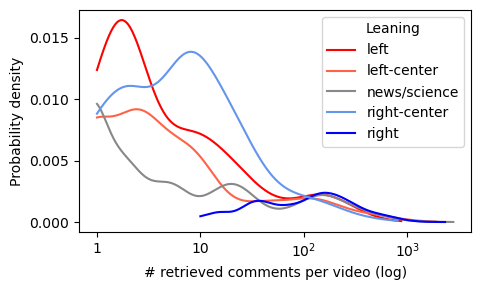

In [ ]:
# Visualization of number of retrieved comments per video

leaning_colors = {
    "left": "red",
    "left-center":"tomato", 
    "news/science": "#888888",
    "right-center": "cornflowerblue",
    "right": "blue"
}


video_level = (
    merge_df
    .groupby(["video_id", "leaning"], as_index=False)
    .agg(retrieved_comments=("comment_id", "nunique"))
)

plt.figure(figsize=(5, 3))

for lean, sub in video_level.groupby("leaning"):
    data = pd.to_numeric(sub["retrieved_comments"], errors="coerce").astype(float).values
    data = data[np.isfinite(data) & (data > 0)]

    log_data = np.log(data)
    kde = gaussian_kde(log_data)

    x_log = np.linspace(log_data.min(), log_data.max(), 400)
    y_log = kde(x_log)           
    x = np.exp(x_log)            
    y = y_log / x                

    color = leaning_colors.get(lean, "#444444")
    plt.plot(x, y, label=str(lean), color=color)

desired_order = ["left", "left-center", "news/science", "right-center", "right"]
handles, labels = plt.gca().get_legend_handles_labels()
handle_dict = dict(zip(labels, handles))
ordered_handles = [handle_dict[lab] for lab in desired_order if lab in handle_dict]
ordered_labels = [lab for lab in desired_order if lab in handle_dict]

plt.xscale("log")
plt.xlabel("# retrieved comments per video (log)")
plt.ylabel("Probability density")
#plt.title("PDF of retrieved comments per video by leaning")
plt.legend(ordered_handles, ordered_labels, title="Leaning")

# plt.gca().xaxis.set_minor_formatter(NullFormatter())
plt.gca().xaxis.set_minor_locator(NullLocator())
plt.gca().xaxis.set_major_formatter(FuncFormatter(custom_log_formatter))
plt.tight_layout()
plt.show()


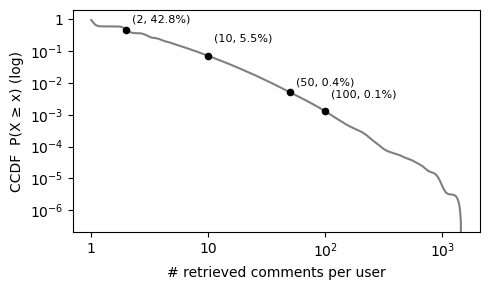

In [ ]:
# Visualizing CCDF for number of retrieved comments per user

# Per-user comment counts (unique comments per user)
per_user = (
    merge_df
    .groupby("author_channel_id")["comment_id"]
    .nunique()                      # ensure each comment counted once
    .rename("n_comments")
    .reset_index()
)

# Strictly positive counts for log transforms
data = per_user["n_comments"].astype(float).values
data = data[data > 0]
if data.size < 5:
    raise ValueError("Not enough users with comments > 0 to build a smooth CCDF.")

# KDE in log-space
log_data = np.log(data)
kde = gaussian_kde(log_data)

# Grid in original space
x = np.logspace(np.log10(data.min()), np.log10(data.max()), 600)

# Density transform back to original spacex
y = kde(np.log(x)) / x

# Numerical integration to get CDF, then CCDF = 1 - CDF
dx = np.diff(x)
y_mid = (y[:-1] + y[1:]) / 2
cdf = np.cumsum(y_mid * dx)
cdf = cdf / cdf[-1]               
ccdf = 1 - cdf
x_mid = (x[:-1] + x[1:]) / 2

# Empirical CCDF (optional, as a sanity check)
data_sorted = np.sort(data)
emp_ccdf_x = data_sorted
emp_ccdf_y = 1.0 - np.arange(1, len(data_sorted) + 1) / len(data_sorted)


# Markers: % of users with >= k comments
thresholds = [2, 10, 50, 100]
num_users = len(per_user)
marks = []
for k in thresholds:
    n_ge  = int((per_user['n_comments'] >= k).sum())
    pct   = (n_ge / num_users) * 100.0
    if (k >= x_mid.min()) and (k <= x_mid.max()):
        y_smooth = float(np.interp(np.log(k), np.log(x_mid), ccdf))
        marks.append({'x': k, 'y': y_smooth, 'n': n_ge, 'pct': pct})

marks=pd.DataFrame(marks)


# Visualization
plt.figure(figsize=(5, 3))
ax = plt.gca()
ax.plot(x_mid, ccdf, label="Smooth CCDF", color="grey")

# Labeled dots on smooth CCDF
if not marks.empty:
    ax.scatter(marks['x'], marks['y'], s=20, color='k', zorder=5)
    for i, r in marks.iterrows():
        ax.annotate(
            f"({int(r['x'])}, {r['pct']:.1f}%)",
            xy=(r['x'], r['y']),
            xytext=(4, 5 if i % 2 == 0 else +10),
            textcoords='offset points',
            fontsize=8, color='k'
        )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("# retrieved comments per user")
ax.set_ylabel("CCDF  P(X ≥ x) (log)")
#ax.set_title("Log CCDF of comments per user")
ax.xaxis.set_minor_formatter(NullFormatter())
ax.xaxis.set_minor_locator(NullLocator())
ax.xaxis.set_major_formatter(FuncFormatter(custom_log_formatter))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_locator(NullLocator())
ax.yaxis.set_major_formatter(FuncFormatter(custom_log_formatter))
plt.tight_layout()
plt.show()

C:\Users\jonas\AppData\Local\Temp\ipykernel_3472\1547496458.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


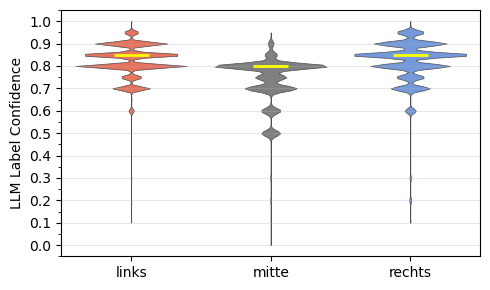

In [ ]:
# Visualizing confidence distribution of LLM Labeling

order   = ['links','mitte','rechts'] 
palette = {'links':'tomato','mitte':'grey','rechts':'cornflowerblue'}

agg_df = (
    merge_df
    .groupby('author_channel_id')
    .agg({
        'user_conf_llm': 'mean',
        'user_label_llm': 'first'
    }))

plt.figure(figsize=(5,3))
ax = sns.violinplot(
    data=agg_df, x='user_label_llm', y='user_conf_llm',
    order=order, palette=palette, inner=None, cut=0, linewidth=0.5
)

sns.boxplot(
    data=user_labels_df, x='user_label_llm', y='user_conf_llm',
    order=order, showcaps=False, showfliers=False, width=0.25,
    whiskerprops={'visible': False}, 
    boxprops={'facecolor':'none','edgecolor':'k','linewidth':1.6, 'visible':False},
    medianprops={'color':'yellow','linewidth':2},
    ax=ax, zorder=3
)

ax.yaxis.set_major_locator(MultipleLocator(0.10))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylabel("LLM Label Confidence")
ax.set_xlabel("")
plt.gca().grid(axis='y',  alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Count comments per user
user_comment_counts = merge_df["author_channel_id"].value_counts()

# Filter to only users with ≥ k comments
active_users = user_comment_counts[user_comment_counts >= 1].index

# Filter original DataFrame
filtered_df = merge_df[
    (merge_df["author_channel_id"].isin(active_users)) &
    (merge_df["user_conf_llm"] >= 0.8)
]

# Count unique users per label
filtered_df.groupby("user_label_llm")["author_channel_id"].nunique()


user_label_llm
links     56565
mitte     27915
rechts    80526
Name: author_channel_id, dtype: int64

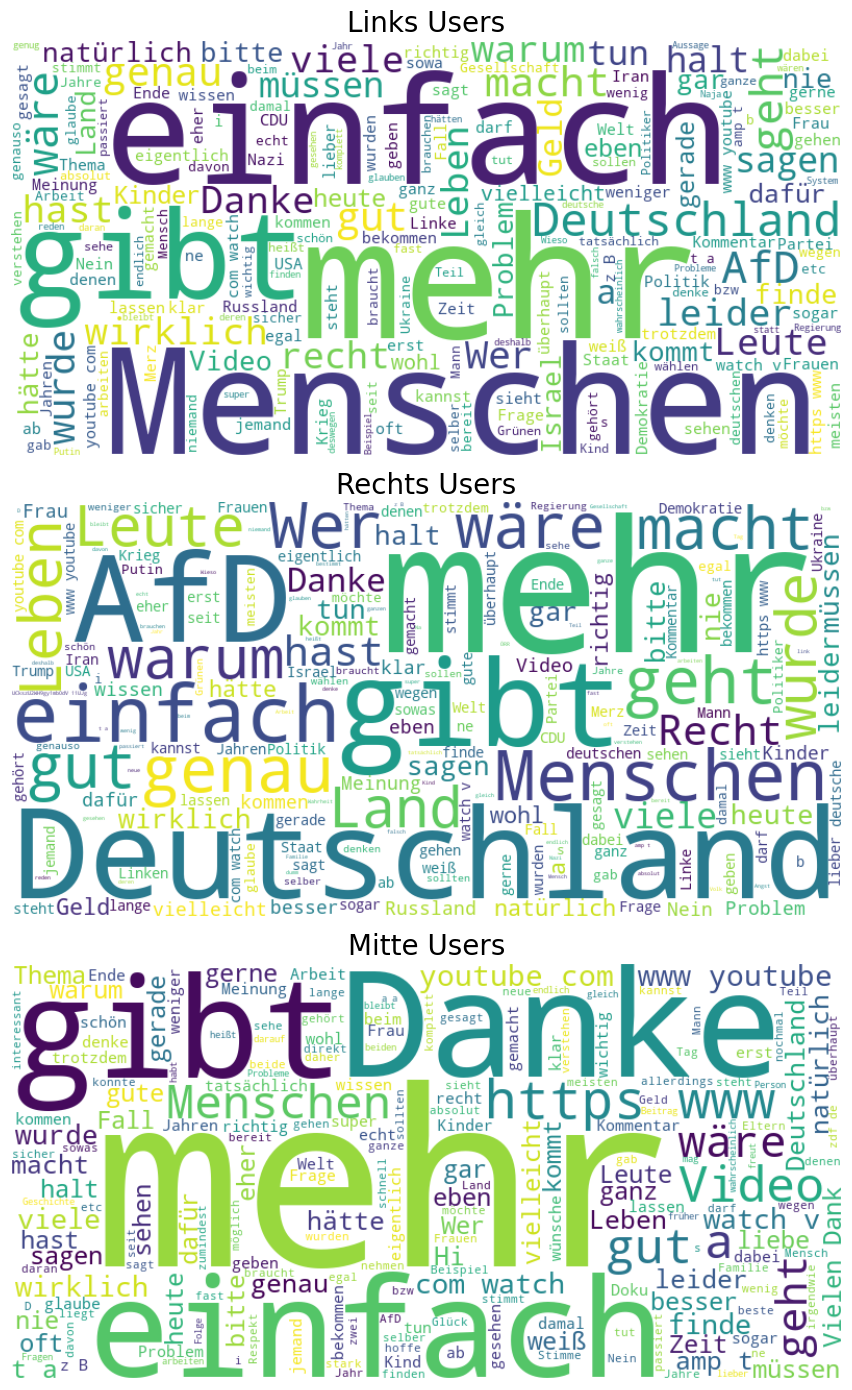

In [ ]:
# WordCloud Visualization:

## Combine NLTK German stopwords + custom ones
german_stopwords = set(stopwords.words('german'))
custom_stopwords = german_stopwords.union({'quot',"br", "ja", "immer", "mal","href", "schon"})

## Prepare text for each group
def get_clean_text(df, label):
    text = " ".join(df[df['user_label_llm'] == label]['comment_text'].dropna())
    return text

left_text = get_clean_text(filtered_df, 'links')
right_text = get_clean_text(filtered_df, 'rechts')
mitte_text = get_clean_text(filtered_df, 'mitte')

## Create word clouds with stopwords removed
left_wc = WordCloud(width=800, height=400, background_color='white',
                    stopwords=custom_stopwords).generate(left_text)

right_wc = WordCloud(width=800, height=400, background_color='white',
                     stopwords=custom_stopwords).generate(right_text)

mitte_wc = WordCloud(width=800, height=400, background_color='white',
                     stopwords=custom_stopwords).generate(mitte_text)

## Plot
fig, axes = plt.subplots(3, 1, figsize=(20, 14))

axes[0].imshow(left_wc, interpolation='bilinear')
axes[0].set_title('Links Users', fontsize=20)
axes[0].axis('off')

axes[1].imshow(right_wc, interpolation='bilinear')
axes[1].set_title('Rechts Users', fontsize=20)
axes[1].axis('off')

axes[2].imshow(mitte_wc, interpolation='bilinear')
axes[2].set_title('Mitte Users', fontsize=20)
axes[2].axis('off')


plt.tight_layout()
plt.show()

## User-Level

### Users who posted at least once

In [ ]:

# Prepare unique author–label–channel-leaning combos
df_unique = filtered_df[['author_channel_id', 'user_label_llm', 'channel_id', 'leaning']].drop_duplicates()


# Five-category crosstab (counts and shares)
five_cols = ['left', 'left-center', 'news/science', 'right', 'right-center']

crosstab_counts_5 = pd.crosstab(
    index=df_unique['user_label_llm'],
    columns=df_unique['leaning'],
    values=df_unique['author_channel_id'],
    aggfunc='nunique',
    dropna=False
).reindex(columns=five_cols).fillna(0).astype(int)

print("\n=== Counts (5 leanings) — distinct users who commented at least once ===")
print(crosstab_counts_5)

# Total distinct users per user_label_llm
totals = df_unique.groupby('user_label_llm')['author_channel_id'].nunique()

crosstab_shares_5 = crosstab_counts_5.div(totals, axis=0)
crosstab_percent_5 = (crosstab_shares_5 * 100).round(2)

print("\n=== Shares % (5 leanings) — of all users in each user_label_llm ===")
print(crosstab_percent_5)

# Three-category (merged) crosstab (counts and shares)
lean_map = {
    'left': 'left',
    'left-center': 'left',
    'news/science': 'news/science',
    'right': 'right',
    'right-center': 'right',
}
df_unique['leaning_3'] = df_unique['leaning'].astype(str).map(lean_map)

three_cols = ['left', 'news/science', 'right']
df_unique['leaning_3'] = pd.Categorical(df_unique['leaning_3'], categories=three_cols, ordered=True)

crosstab_counts_3 = pd.crosstab(
    index=df_unique['user_label_llm'],
    columns=df_unique['leaning_3'],
    values=df_unique['author_channel_id'],
    aggfunc='nunique',
    dropna=False
).reindex(columns=three_cols).fillna(0).astype(int)

print("\n=== Counts (3 merged leanings) — distinct users who commented at least once ===")
print(crosstab_counts_3)

# use the SAME totals denominator (total users per user_label_llm)
crosstab_shares_3 = crosstab_counts_3.div(totals, axis=0)
crosstab_percent_3 = (crosstab_shares_3 * 100).round(2)

print("\n=== Shares % (3 merged leanings) — of all users in each user_label_llm ===")
print(crosstab_percent_3)



=== Counts (5 leanings) — distinct users who commented at least once ===
leaning          left  left-center  news/science  right  right-center
user_label_llm                                                       
links           11814        21825         22618  11977          2489
mitte            2704         8744         16561   1612          1801
rechts           8274        22790         27038  42377          5754

=== Shares % (5 leanings) — of all users in each user_label_llm ===
leaning          left  left-center  news/science  right  right-center
user_label_llm                                                       
links           20.89        38.58         39.99  21.17          4.40
mitte            9.69        31.32         59.33   5.77          6.45
rechts          10.27        28.30         33.58  52.63          7.15

=== Counts (3 merged leanings) — distinct users who commented at least once ===
leaning_3        left  news/science  right
user_label_llm                   

In [ ]:
## Bootstrapping 


B = 5000           # number of sub-sample replicates
m_frac = 1        # sub-sample size as a fraction of n (e.g., 0.5~0.8)
replace = True    # False = subsample without replacement; True = with replacement
alpha = 0.05
seed = 42

rng_global = np.random.default_rng(seed)

def subsample_bootstrap_mean_median(x, B=2000, m=None, replace=False, alpha=0.05, rng=None):
    """
    Subsample (m-out-of-n) 'bootstrap' for mean + quartiles.
    Returns mean point, bootstrap SE of mean, 95% CI for mean,
    Q1/Q3 points with 95% CIs, and a median *point* estimate.
    """
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    n = x.size
    if n == 0:
        return dict(n_users=0,
                    mean_point=np.nan, mean_se_boot=np.nan, mean_ci_lo=np.nan, mean_ci_hi=np.nan,
                    q1_point=np.nan, q1_ci_lo=np.nan, q1_ci_hi=np.nan,
                    q3_point=np.nan, q3_ci_lo=np.nan, q3_ci_hi=np.nan,
                    iqr_point=np.nan, iqr_ci_lo=np.nan, iqr_ci_hi=np.nan,
                    median_point=np.nan)

    if m is None:
        m = min(n, int(np.ceil(m_frac * n)))

    rng = rng or np.random.default_rng()
    means = np.empty(B, dtype=float)
    q1s   = np.empty(B, dtype=float)
    q3s   = np.empty(B, dtype=float)

    for b in range(B):
        idx = rng.integers(0, n, size=m) if replace else rng.choice(n, size=m, replace=False)
        xb = x[idx]
        means[b] = xb.mean()
        q1s[b]   = np.quantile(xb, 0.25)
        q3s[b]   = np.quantile(xb, 0.75)

    mean_point = float(np.mean(means))
    q1_point   = float(np.quantile(x, 0.25))
    q3_point   = float(np.quantile(x, 0.75))
    iqr_point  = q3_point - q1_point
    median_point = float(np.quantile(x, 0.5))  

    mean_se_boot = float(np.std(means, ddof=1)) if B > 1 else np.nan
    mean_ci_lo, mean_ci_hi = np.percentile(means, [100*alpha/2, 100*(1-alpha/2)])
    q1_ci_lo, q1_ci_hi     = np.percentile(q1s,   [100*alpha/2, 100*(1-alpha/2)])
    q3_ci_lo, q3_ci_hi     = np.percentile(q3s,   [100*alpha/2, 100*(1-alpha/2)])
    iqr_ci_lo, iqr_ci_hi   = np.percentile(q3s - q1s, [100*alpha/2, 100*(1-alpha/2)])

    return dict(
        n_users=int(n),
        mean_point=mean_point, mean_se_boot=mean_se_boot,
        mean_ci_lo=float(mean_ci_lo), mean_ci_hi=float(mean_ci_hi),
        q1_point=float(q1_point), q1_ci_lo=float(q1_ci_lo), q1_ci_hi=float(q1_ci_hi),
        q3_point=float(q3_point), q3_ci_lo=float(q3_ci_lo), q3_ci_hi=float(q3_ci_hi),
        iqr_point=float(iqr_point), iqr_ci_lo=float(iqr_ci_lo), iqr_ci_hi=float(iqr_ci_hi),
        median_point=median_point,
        mean_reps=means.copy()  
    )


### User's cross partisan interaction

In [ ]:

df = filtered_df.copy()

# Keep only links/rechts users
df = df[df['user_label_llm'].isin(['links', 'rechts'])].copy()

# Per-user totals and counts per leaning
five = ['left', 'left-center', 'news/science', 'right', 'right-center']

totals = (
    df.groupby(['author_channel_id', 'user_label_llm'])
      .size().rename('total_comments').reset_index()
)

counts = (
    df.groupby(['author_channel_id', 'user_label_llm', 'leaning'])
      .size().rename('cnt').reset_index()
)

wide = (
    counts.pivot_table(index=['author_channel_id', 'user_label_llm'],
                       columns='leaning', values='cnt',
                       aggfunc='sum', fill_value=0)
          .reindex(columns=five, fill_value=0)
          .reset_index()
)

wide = wide.merge(totals, on=['author_channel_id', 'user_label_llm'], how='left')

# Per-user shares (each user weighted equally)
for col in five:
    wide[f'share_{col}'] = wide[col] / wide['total_comments']

# Summary targets
targets = {
    'rechts': ['left', 'left-center', 'news/science',"right-center","right"],
    'links' : ['right', 'right-center', 'news/science',"left-center","left"],
}

# Run bootstrapping for groups
boot_reps_rows = [] 
summary_frames = []
for lab, leans in targets.items():
    sub = wide[wide['user_label_llm'] == lab]
    out_rows = []
    for ln in leans:
        x = sub[f'share_{ln}'].to_numpy(dtype=float)
        stats = subsample_bootstrap_mean_median(
            x, B=B, m=None, replace=replace, alpha=alpha, rng=rng_global
        )
        out_rows.append({
        'user_label_llm': lab,
        'leaning': ln,
        'n_users': stats['n_users'],
        'mean_share': stats['mean_point'],
        'mean_se_boot': stats['mean_se_boot'],
        'mean_ci_lo': stats['mean_ci_lo'],
        'mean_ci_hi': stats['mean_ci_hi'],
        'q1_share': stats['q1_point'],
        'median_share': stats['median_point'],
        'q3_share': stats['q3_point'],
        })
        boot_reps_rows.append(pd.DataFrame({
            'user_label_llm': lab,
            'leaning': ln,
            'rep_idx': np.arange(len(stats['mean_reps'])),
            'rep_mean_pct': stats['mean_reps'] * 100.0
        }))

    summary_frames.append(pd.DataFrame(out_rows))

summary_subboot = pd.concat(summary_frames, ignore_index=True)

pct_cols = [
    'mean_share','mean_se_boot','mean_ci_lo','mean_ci_hi',
    'q1_share',
    'q3_share',
    'median_share' 
]
summary_pct = summary_subboot.copy()
summary_pct[pct_cols] = (summary_pct[pct_cols] * 100).round(2)

print(summary_pct.sort_values(['user_label_llm','leaning']))

  user_label_llm       leaning  n_users  mean_share  mean_se_boot  mean_ci_lo  \
9          links          left    56565       15.93          0.15       15.65   
8          links   left-center    56565       30.77          0.18       30.42   
7          links  news/science    56565       32.52          0.18       32.16   
5          links         right    56565       17.90          0.16       17.61   
6          links  right-center    56565        2.88          0.06        2.75   
0         rechts          left    80526        6.17          0.08        6.02   
1         rechts   left-center    80526       19.76          0.13       19.52   
2         rechts  news/science    80526       24.67          0.14       24.41   
4         rechts         right    80526       45.38          0.17       45.05   
3         rechts  right-center    80526        4.01          0.06        3.89   

   mean_ci_hi  q1_share  median_share  q3_share  
9       16.22       0.0           0.0      0.00  
8       

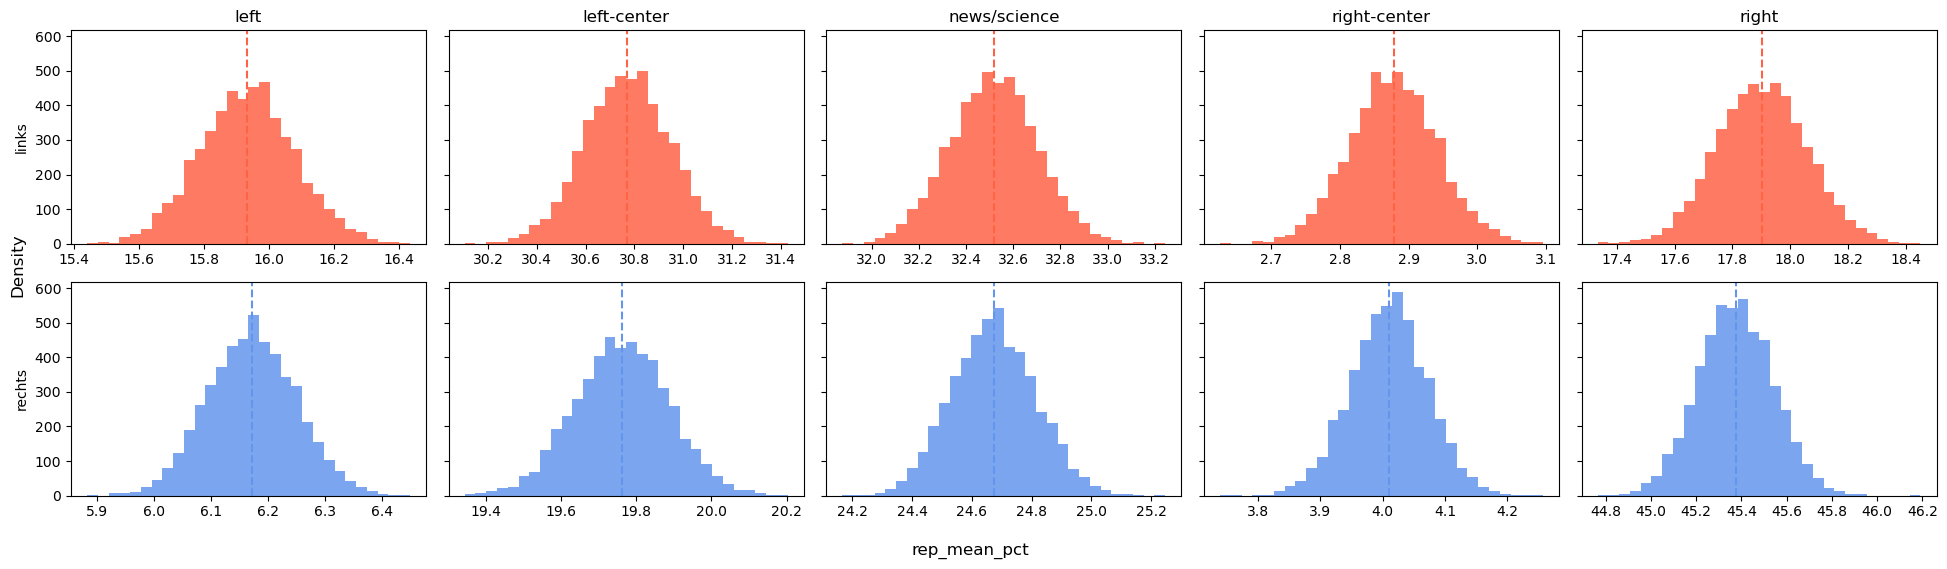

In [ ]:
## Visualize Bootstrapping Distribution in facets

df = pd.concat(boot_reps_rows, ignore_index=True)

# Facet order
user_order = ['links', 'rechts']
lean_order = ['left', 'left-center', 'news/science', 'right-center', 'right']  

df['user_label_llm'] = pd.Categorical(df['user_label_llm'], categories=user_order, ordered=True)
df['leaning']        = pd.Categorical(df['leaning'],        categories=lean_order, ordered=True)

colors = {'links': 'tomato', 'rechts': 'cornflowerblue'}

nrows, ncols = len(user_order), len(lean_order)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), sharex=False, sharey=True)

def facet_bins(x, n=30):
    x = np.asarray(x, dtype=float)
    xmin, xmax = float(np.min(x)), float(np.max(x))
    span = xmax - xmin
    if span == 0:
        pad = max(1e-6, abs(xmin) * 0.005)
        xmin, xmax = xmin - pad, xmax + pad
    return np.linspace(xmin, xmax, n+1)

for r, user in enumerate(user_order):
    for c, lean in enumerate(lean_order):
        ax = axes[r, c]
        sub = df[(df['user_label_llm'] == user) & (df['leaning'] == lean)]
        if sub.empty:
            ax.axis('off')
            continue

        bins = facet_bins(sub['rep_mean_pct'].to_numpy(), n=30)
        ax.hist(sub['rep_mean_pct'].to_numpy(), bins=bins, density=False,
                color=colors[user], alpha=0.85)
        ax.axvline(float(sub['rep_mean_pct'].mean()), linestyle='--',
                   color=colors[user], linewidth=1.5)

        if r == 0:
            ax.set_title(lean)
        if c == 0:
            ax.set_ylabel(user)

fig.supxlabel('rep_mean_pct')
fig.supylabel('Density')
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()



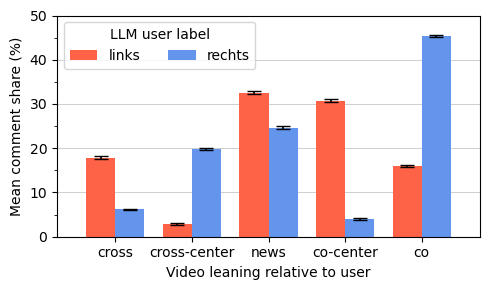

In [ ]:

# Visualize Cross-commenting estimate
cat_order = ['cross', 'cross-center', 'news', 'co-center', 'co']

mapping = {
    'links': {
        'cross': 'right',
        'cross-center': 'right-center',
        'news': 'news/science',
        'co-center': 'left-center',
        'co': 'left',
    },
    'rechts': {
        'cross': 'left',
        'cross-center': 'left-center',
        'news': 'news/science',
        'co-center': 'right-center',
        'co': 'right',
    }
}

# Join table and merge with summary (already in %)
want = []
for lbl, d in mapping.items():
    for cat, lean in d.items():
        want.append({'user_label_llm': lbl, 'leaning': lean, 'x_cat': cat})
want = pd.DataFrame(want)

viz = (want.merge(summary_pct, on=['user_label_llm','leaning'], how='left')
           .set_index('x_cat')
           .loc[cat_order]       
           .reset_index())

# Plotting Prep
color_map = {'links': 'tomato', 'rechts': 'cornflowerblue'}
bar_width = 0.38
x_idx = np.arange(len(cat_order))

fig, ax = plt.subplots(figsize=(5, 3))

for j, lbl in enumerate(['links', 'rechts']):
    d = (viz[viz['user_label_llm'] == lbl]
         .set_index('x_cat')
         .reindex(cat_order)) 

    y = d['mean_share'].to_numpy()
    lo = (y - d['mean_ci_lo'].to_numpy())
    hi = (d['mean_ci_hi'].to_numpy() - y)
    yerr = np.vstack([lo, hi])  

    xpos = x_idx + (j - 0.5) * bar_width 
    ax.bar(
        xpos, y, width=bar_width,
        color=color_map[lbl], label=lbl,
        yerr=yerr, capsize=5, error_kw={'elinewidth': 1.2}
    )

ax.set_xticks(x_idx, cat_order)
ax.set_xlim(x_idx[0] - 2*bar_width, x_idx[-1] + 2*bar_width)
ax.set_ylim(0, 50)
ax.set_ylabel('Mean comment share (%)')
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlabel('Video leaning relative to user')
ax.grid(axis='y', linewidth=0.7, alpha=0.6)
ax.set_axisbelow(True)
ax.legend(title='LLM user label', frameon=True, ncols=3)

fig.tight_layout()
plt.show()



In [ ]:
# Bootstrap config for bins 
B = 5000         # number of replicates (↑ for tighter CIs)
m_frac = 1     # subsample size as a fraction of n in each bin
replace = True  
alpha = 0.05
seed = 42

rng_global = np.random.default_rng(seed)

def boot_bin_stats(x, B=2000, m=None, replace=False, alpha=0.05, rng=None, with_quartiles=True):
    """
    Subsample/bootstrap within a bin over users' shares x (0..1).
    Returns mean point, bootstrap SE, 95% CI; plus Q1/Q3/IQR CIs if requested.
    """
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    n = x.size
    if n == 0:
        base = dict(n_authors=0, mean=np.nan, mean_se_boot=np.nan, ci_lo=np.nan, ci_hi=np.nan)
        if with_quartiles:
            base.update(q1=np.nan, q3=np.nan, iqr=np.nan,
                        q1_ci_lo=np.nan, q1_ci_hi=np.nan,
                        q3_ci_lo=np.nan, q3_ci_hi=np.nan,
                        iqr_ci_lo=np.nan, iqr_ci_hi=np.nan)
        return pd.Series(base)

    if m is None:
        m = min(n, int(np.ceil(m_frac * n)))

    rng = rng or np.random.default_rng()
    means = np.empty(B, float)
    if with_quartiles:
        q1s = np.empty(B, float)
        q3s = np.empty(B, float)

    for b in range(B):
        idx = (rng.integers(0, n, size=m) if replace else rng.choice(n, size=m, replace=False))
        xb = x[idx]
        means[b] = xb.mean()
        if with_quartiles:
            q1s[b] = np.quantile(xb, 0.25)
            q3s[b] = np.quantile(xb, 0.75)

    # point estimates on full bin
    mean_pt = float(np.mean(means))

    mean_se = float(np.std(means, ddof=1)) if B > 1 else np.nan
    lo_m, hi_m = np.percentile(means, [100*alpha/2, 100*(1-alpha/2)])

    out = dict(n_authors=int(n), mean=mean_pt, mean_se_boot=mean_se, ci_lo=float(lo_m), ci_hi=float(hi_m))

    if with_quartiles:
        q1_pt = float(np.quantile(x, 0.25)); q3_pt = float(np.quantile(x, 0.75))
        iqr_pt = q3_pt - q1_pt
        lo_q1, hi_q1 = np.percentile(q1s, [100*alpha/2, 100*(1-alpha/2)])
        lo_q3, hi_q3 = np.percentile(q3s, [100*alpha/2, 100*(1-alpha/2)])
        lo_iqr, hi_iqr = np.percentile(q3s - q1s, [100*alpha/2, 100*(1-alpha/2)])
        out.update(q1=q1_pt, q3=q3_pt, iqr=iqr_pt,
                   q1_ci_lo=float(lo_q1), q1_ci_hi=float(hi_q1),
                   q3_ci_lo=float(lo_q3), q3_ci_hi=float(hi_q3),
                   iqr_ci_lo=float(lo_iqr), iqr_ci_hi=float(hi_iqr))
    return pd.Series(out)

In [ ]:


df = filtered_df.copy()

# Keep only links/rechts users
df = df[df['user_label_llm'].isin(['links', 'rechts'])].copy()

# Total comments per author
author_totals = (
    df.groupby('author_channel_id')
      .size().rename('total_comments').reset_index()
)

# Per-author counts per merged leaning
counts = (
    df.groupby(['author_channel_id', 'user_label_llm', 'leaning_3'])
      .size().rename('cnt').reset_index()
)

three_cols = ['left', 'news/science', 'right']
wide = (
    counts.pivot_table(index=['author_channel_id', 'user_label_llm'],
                       columns='leaning_3', values='cnt',
                       aggfunc='sum', fill_value=0)
          .reindex(columns=three_cols, fill_value=0)
          .reset_index()
)

# Merge totals and compute per-author shares for each leaning
wide = wide.merge(author_totals, on='author_channel_id', how='left')
for col in three_cols:
    wide[f'share_{col}'] = wide[col] / wide['total_comments']

# Long form: one row per author × leaning
per_author = wide.melt(
    id_vars=['author_channel_id', 'user_label_llm', 'total_comments'],
    value_vars=[f'share_{c}' for c in three_cols],
    var_name='leaning_3_tmp', value_name='share'
)
per_author['leaning_3'] = per_author['leaning_3_tmp'].str.replace('share_', '', regex=False)
per_author = per_author.drop(columns=['leaning_3_tmp'])

# Bin authors by total comments: 15 log-spaced bins; bootstrap within bins
n_bins = 15
max_total = max(2, int(per_author['total_comments'].max()))
edges = np.logspace(np.log10(1), np.log10(max_total), num=n_bins+1)
mid_labels = np.sqrt(edges[:-1] * edges[1:])

per_author['bin_mid'] = pd.cut(
    per_author['total_comments'].clip(lower=1),
    bins=edges, labels=mid_labels, include_lowest=True
).astype(float)
per_author = per_author.dropna(subset=['bin_mid'])

agg_boot = (
    per_author
    .groupby(['leaning_3', 'user_label_llm', 'bin_mid'], as_index=False)
    .apply(lambda g: boot_bin_stats(g['share'], B=B, m=None, replace=replace, alpha=alpha, rng=rng_global, with_quartiles=False))
    .reset_index(drop=True)
)


color_map = {'links': 'tomato', 'rechts': 'cornflowerblue'}

# Require a minimum number of authors per bin
MIN_N = 20 

#  Cross-partisan in one figure (bootstrap mean ± CI) 
sub_cross = pd.concat([
    agg_boot[(agg_boot['leaning_3']=='right') & (agg_boot['user_label_llm']=='links')],
    agg_boot[(agg_boot['leaning_3']=='left')  & (agg_boot['user_label_llm']=='rechts')]
], ignore_index=True)
if MIN_N: sub_cross = sub_cross[sub_cross['n_authors'] >= MIN_N]

# News/Science (both groups)
sub_news = agg_boot[(agg_boot['leaning_3']=='news/science') & (agg_boot['user_label_llm'].isin(['links','rechts']))].copy()
if MIN_N: sub_news = sub_news[sub_news['n_authors'] >= MIN_N]

C:\Users\jonas\AppData\Local\Temp\ipykernel_3472\2076041426.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: boot_bin_stats(g['share'], B=B, m=None, replace=replace, alpha=alpha, rng=rng_global, with_quartiles=False))


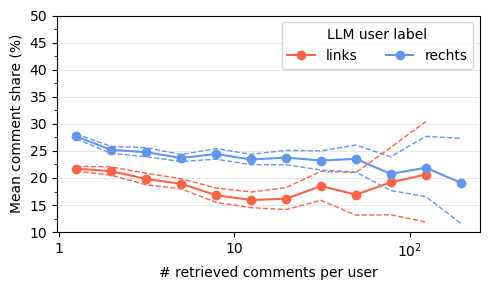

In [ ]:
# Visualization

plt.figure(figsize=(5,3))

# links → right
s = sub_cross[(sub_cross['user_label_llm']=='links') & (sub_cross['leaning_3']=='right')].sort_values('bin_mid')
if not s.empty:
    x, y = s['bin_mid'], s['mean']*100
    lo, hi = s['ci_lo']*100, s['ci_hi']*100
    c = color_map['links']
    plt.plot(x, y, marker='o', linestyle='-', color=c, label='links')
    plt.plot(x, lo, linestyle='--', linewidth=1, color=c)
    plt.plot(x, hi, linestyle='--', linewidth=1, color=c)

# rechts → left
s = sub_cross[(sub_cross['user_label_llm']=='rechts') & (sub_cross['leaning_3']=='left')].sort_values('bin_mid')
if not s.empty:
    x, y = s['bin_mid'], s['mean']*100
    lo, hi = s['ci_lo']*100, s['ci_hi']*100
    c = color_map['rechts']
    plt.plot(x, y, marker='o', linestyle='-', color=c, label='rechts')
    plt.plot(x, lo, linestyle='--', linewidth=1, color=c)
    plt.plot(x, hi, linestyle='--', linewidth=1, color=c)

ax = plt.gca()
ax.set_xscale('log')
ax.set_xlabel('# retrieved comments per user')
ax.xaxis.set_minor_formatter(NullFormatter())
ax.xaxis.set_minor_locator(NullLocator())
ax.xaxis.set_major_formatter(FuncFormatter(custom_log_formatter))

ax.set_ylabel('Mean comment share (%)')

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(2.5))
ax.set_ylim(10, 50) 
ax.grid(axis='y',  alpha=0.3)
#ax.set_title('Cross-partisan interaction (bootstrap mean ± 95% CI)')
ax.legend(title='LLM user label', frameon=True, ncols=3)
plt.tight_layout()
plt.show()

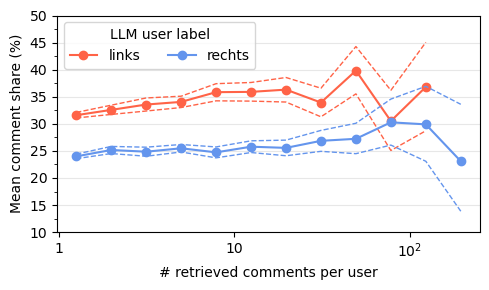

In [ ]:
# Visualization

plt.figure(figsize=(5,3))
for lab in ['links','rechts']:
    s = sub_news[sub_news['user_label_llm']==lab].sort_values('bin_mid')
    if s.empty: continue
    x, y = s['bin_mid'], s['mean']*100
    lo, hi = s['ci_lo']*100, s['ci_hi']*100
    c = color_map[lab]
    plt.plot(x, y, marker='o', linestyle='-', color=c, label=f'{lab}')
    plt.plot(x, lo, linestyle='--', linewidth=1, color=c)
    plt.plot(x, hi, linestyle='--', linewidth=1, color=c)

ax=plt.gca()
ax.set_xscale('log')
ax.set_xlabel('# retrieved comments per user')
ax.xaxis.set_minor_formatter(NullFormatter())
ax.xaxis.set_minor_locator(NullLocator())
ax.xaxis.set_major_formatter(FuncFormatter(custom_log_formatter))
ax.set_ylabel('Mean comment share (%)')
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(2.5))
ax.set_ylim(10, 50)
ax.grid(axis='y',  alpha=0.3)
#plt.title('News/Science (bootstrap mean ± 95% CI)')
ax.legend(title='LLM user label', frameon=True, ncols=3)
plt.tight_layout()
plt.show()

## Video cross partisan interaction

In [ ]:

# filtered_df: ALL comments (identified + unidentified)
# filtered_df: ONLY comments from users with a clear political leaning 
df_all = merge_df.copy()
df_id  = filtered_df.copy()

# Per-video totals (ALL comments) and per-group counts (identified only)
five_leanings = ['right', 'right-center', 'news/science', 'left-center', 'left']
user_groups   = ['links','mitte','rechts']

# Totals from ALL comments (denominator)
tot_per_video = (
    df_all.groupby('video_id').size()
          .rename('n_total_all')
          .reset_index()
)

# Labeled counts from identified subset (numerator)
lab_counts = (
    df_id[df_id['user_label_llm'].isin(user_groups)]
        .groupby(['video_id','user_label_llm']).size()
        .rename('n_label').reset_index()
        .pivot(index='video_id', columns='user_label_llm', values='n_label')
        .reindex(columns=user_groups, fill_value=0)
        .reset_index()
)

# Video metadata (leaning, views) from ALL comments (first observed per video)
video_meta = (
    df_all.groupby('video_id', as_index=False)
          .agg(leaning=('leaning','first'),
               view_count_video=('view_count_video','first'))
)

# Merge
v = (video_meta
     .merge(tot_per_video, on='video_id', how='left')
     .merge(lab_counts,   on='video_id', how='left'))

# Fill zeros for missing labeled counts, keep only videos with any comments
v[user_groups] = v[user_groups].fillna(0)
v = v[v['n_total_all'] > 0].copy()

# Per-video shares (denominator = ALL comments on the video)
denom = v['n_total_all'].replace(0, np.nan)
for g in user_groups:
    v[f'share_{g}'] = (v[g] / denom).clip(0, 1)

# Keep 5 leanings in order
v = v[v['leaning'].isin(five_leanings)].copy()
v['leaning'] = pd.Categorical(v['leaning'], categories=five_leanings, ordered=True)

# Long form: one row per video × user_group
pv = v.melt(id_vars=['video_id','leaning'],
            value_vars=[f'share_{g}' for g in user_groups],
            var_name='user_group', value_name='share')
pv['user_group'] = pv['user_group'].str.replace('share_','', regex=False)

# SAME bootstrap applied to the per-video shares
rows = []
boot_reps_rows = []
for ln in five_leanings:
    for grp in user_groups:
        x = pv.loc[(pv['leaning']==ln) & (pv['user_group']==grp), 'share'].to_numpy(float)
        stats = subsample_bootstrap_mean_median(
            x, B=B, m=None, replace=replace, alpha=alpha, rng=rng_global
        )
        rows.append({
            'leaning': ln,
            'user_group': grp,
            'n_videos': stats['n_users'],       
            'mean_share': stats['mean_point'],
            'mean_se_boot': stats['mean_se_boot'],
            'mean_ci_lo': stats['mean_ci_lo'],
            'mean_ci_hi': stats['mean_ci_hi'],
            'q1_share': stats['q1_point'],
            'median_share': stats['median_point'],
            'q3_share': stats['q3_point'],
        })
        boot_reps_rows.append(pd.DataFrame({
            'user_label_llm': grp,
            'leaning': ln,
            'rep_idx': np.arange(len(stats['mean_reps'])),
            'rep_mean_pct': stats['mean_reps'] * 100.0
        }))

summary_videos = pd.DataFrame(rows)

# Presentation
pct_cols = ['mean_share','mean_se_boot','mean_ci_lo','mean_ci_hi',
            'q1_share','q3_share','median_share']
summary_videos_pct = summary_videos.copy()
summary_videos_pct[pct_cols] = (summary_videos_pct[pct_cols] * 100).round(2)

print(summary_videos_pct.sort_values(['leaning','user_group']))


         leaning user_group  n_videos  mean_share  mean_se_boot  mean_ci_lo  \
12          left      links       316       49.57          1.34       46.90   
13          left      mitte       316        7.80          0.79        6.32   
14          left     rechts       316       26.47          0.94       24.59   
9    left-center      links       439       28.64          0.87       26.95   
10   left-center      mitte       439       12.94          0.70       11.62   
11   left-center     rechts       439       31.61          0.80       30.01   
6   news/science      links       663       20.86          0.54       19.80   
7   news/science      mitte       663       23.16          0.71       21.75   
8   news/science     rechts       663       27.61          0.67       26.29   
0          right      links       555       12.25          0.39       11.50   
1          right      mitte       555        1.94          0.14        1.69   
2          right     rechts       555       75.03   

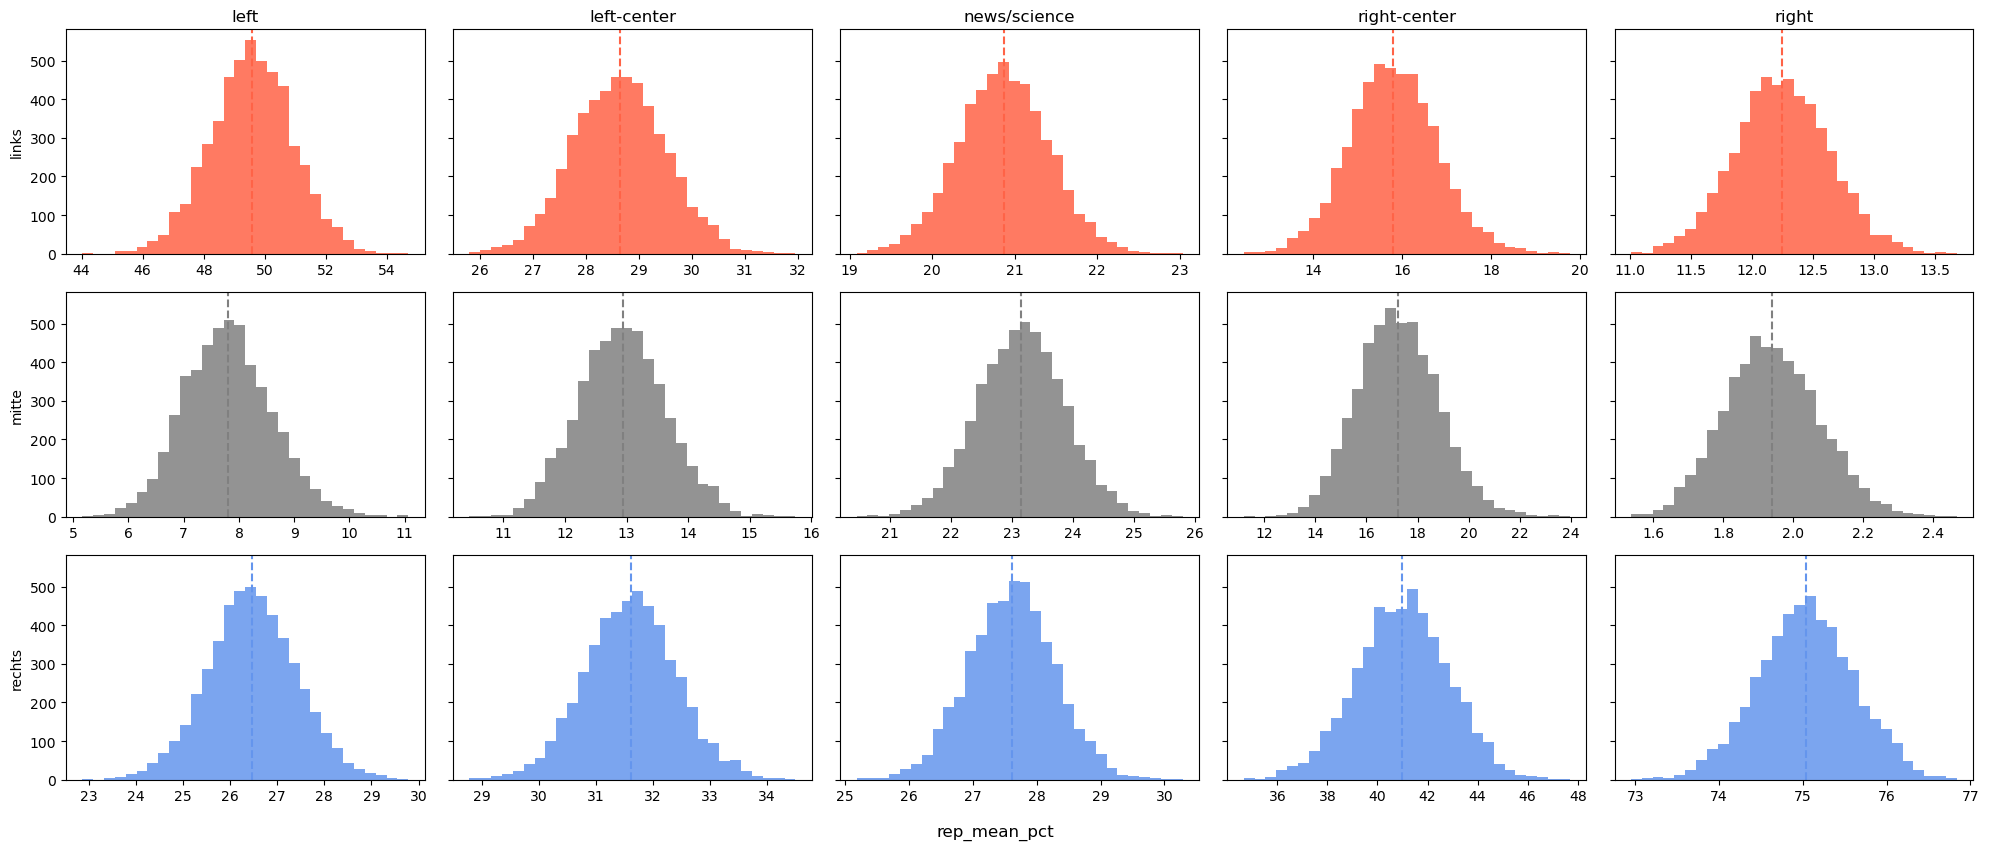

In [ ]:
# Visualize user bootstrapping distributions

# Combine list of DataFrames (video bootstraps)
df = pd.concat(boot_reps_rows, ignore_index=True)

# Facet order
row_order = ['links', 'mitte', 'rechts']  # 3 rows
col_order = ['left', 'left-center', 'news/science', 'right-center', 'right']  # 5 cols

df['user_label_llm'] = pd.Categorical(df['user_label_llm'], categories=row_order, ordered=True)
df['leaning']        = pd.Categorical(df['leaning'],        categories=col_order, ordered=True)

# Colors
colors = {'links': 'tomato', 'mitte': 'gray', 'rechts': 'cornflowerblue'}

nrows, ncols = len(row_order), len(col_order)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), sharex=False, sharey=True)

def facet_bins(x, n=10):
    x = np.asarray(x, dtype=float)
    xmin, xmax = float(np.min(x)), float(np.max(x))
    if xmax == xmin:
        pad = max(1e-6, abs(xmin) * 0.005)
        xmin, xmax = xmin - pad, xmax + pad
    return np.linspace(xmin, xmax, n+1)

for r, user in enumerate(row_order):
    for c, lean in enumerate(col_order):
        ax = axes[r, c]
        sub = df[(df['user_label_llm'] == user) & (df['leaning'] == lean)]
        if sub.empty:
            ax.axis('off')
            continue

        bins = facet_bins(sub['rep_mean_pct'].to_numpy(), n=30)
        ax.hist(sub['rep_mean_pct'].to_numpy(), bins=bins, density=False,
                color=colors[user], alpha=0.85)
        ax.axvline(float(sub['rep_mean_pct'].mean()), linestyle='--',
                   color=colors[user], linewidth=1.5)

        if r == 0:
            ax.set_title(lean)
        if c == 0:
            ax.set_ylabel(user)

fig.supxlabel('rep_mean_pct')
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


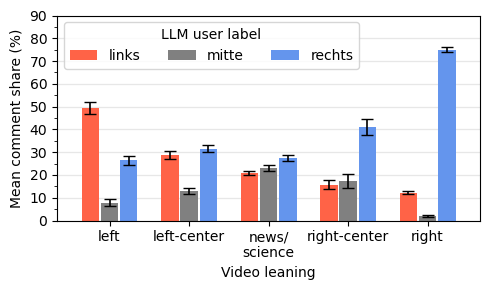

In [ ]:
# Visualize cross-cutting engagement on videos

# Order x-axis (channel leaning)
cat_order = ['left', 'left-center', 'news/science', 'right-center', 'right']

# ensure only use needed columns and keep order
viz = (summary_videos_pct
       .loc[:, ['leaning','user_group','mean_share','mean_ci_lo','mean_ci_hi','n_videos']]
       .copy())
viz['leaning'] = pd.Categorical(viz['leaning'], categories=cat_order, ordered=True)
viz = viz.sort_values(['leaning','user_group'])

# colors and placement
groups = ['links', 'mitte', 'rechts']
color_map = {'links':'tomato', 'mitte':'grey', 'rechts':'cornflowerblue'}

G = len(groups)
bar_width = 0.22
x_idx = np.arange(len(cat_order))

fig, ax = plt.subplots(figsize=(5, 3))

for j, g in enumerate(groups):
    d = (viz[viz['user_group'] == g]
         .set_index('leaning')
         .reindex(cat_order))  
    y   = d['mean_share'].to_numpy()
    lo  = y - d['mean_ci_lo'].to_numpy()
    hi  = d['mean_ci_hi'].to_numpy() - y
    yerr = np.vstack([lo, hi])
    offset = (j - (G-1)/2) * (bar_width * 1.1)
    xpos = x_idx + offset

    ax.bar(
        xpos, y, width=bar_width,
        color=color_map[g], label=g,
        yerr=yerr, capsize=4, error_kw={'elinewidth':1.2}
    )


labels = ['left', 'left-center', 'news/\nscience', 'right-center', 'right']
ax.set_xticks(x_idx, labels)
ax.set_xlim(x_idx[0] - 3*bar_width, x_idx[-1] + 3*bar_width)
ax.set_ylim(0, 90)

ax.set_ylabel('Mean comment share (%)')
ax.set_xlabel('Video leaning')
ax.grid(axis='y' , linewidth=0.9, alpha=0.3)
ax.grid(axis="x", visible=False)
ax.set_axisbelow(True)
ax.legend(title='LLM user label', frameon=True, ncols=3)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
#ax.set_title('Mean comment share by channel leaning — bootstrap mean ±95% CI')

fig.tight_layout()
plt.show()


In [ ]:
# Bootstrap config for video bins
B = 5000          
m_frac = 1      
replace = True
alpha = 0.05
seed = 42
rng_global = np.random.default_rng(seed)

def boot_bin_stats_video(x, B=2000, m=None, replace=False, alpha=0.05, rng=None):
    """
    x: 1D array of per-video shares in this bin (0..1).
    Returns: mean point, bootstrap SE, and percentile 95% CI; plus n_videos.
    """
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    n = x.size
    if n == 0:
        return pd.Series({'mean': np.nan, 'mean_se_boot': np.nan,
                          'ci_lo': np.nan, 'ci_hi': np.nan, 'n_videos': 0})
    if m is None:
        m = min(n, int(np.ceil(m_frac * n)))
    rng = rng or np.random.default_rng()

    means = np.empty(B, float)
    for b in range(B):
        idx = (rng.integers(0, n, size=m) if replace else rng.choice(n, size=m, replace=False))
        means[b] = x[idx].mean()

    mean_pt = float(np.mean(means))
    se_boot = float(np.std(means, ddof=1)) if B > 1 else np.nan
    lo, hi = np.percentile(means, [100*alpha/2, 100*(1-alpha/2)])

    return pd.Series({'mean': mean_pt, 'mean_se_boot': se_boot,
                      'ci_lo': float(lo), 'ci_hi': float(hi), 'n_videos': int(n)})

In [ ]:

# all_df: ALL comments (identified + unidentified)
# filtered_df: ONLY comments from users with a clear political leaning

df_all = merge_df.copy()
df_id  = filtered_df.copy()

# Normalize BEFORE mapping, so news/science is kept 
lean_map = {
    'left': 'left',
    'left-center': 'left',
    'right': 'right',
    'right-center': 'right',
    'news/science': 'news/science',
}

# Video-level metadata from ALL comments (to ensure consistent filter & categories)
video_meta = (
    df_all.groupby('video_id', as_index=False)
          .agg(leaning=('leaning','first'),
               view_count_video=('view_count_video','first'))
)

# Map leanings for plotting
video_meta['leaning_plt'] = video_meta['leaning'].map(lean_map)

# keep videos with >= 1000 views (based on ALL comments' metadata)
video_meta['view_count_video'] = pd.to_numeric(video_meta['view_count_video'], errors='coerce')
video_meta = video_meta[video_meta['view_count_video'].notna()].copy()
video_meta['view_count_video'] = video_meta['view_count_video'].astype(float)
video_meta = video_meta[video_meta['view_count_video'] >= 1000].copy()

# Per-video shares using ALL comments as denominator ---
# Denominator from ALL comments
tot_per_video_all = (
    df_all.groupby('video_id').size()
          .rename('n_total_all').reset_index()
)

# Numerators (identified only) — links/rechts
lab = df_id[df_id['user_label_llm'].isin(['links', 'rechts'])].copy()
lab_counts = (
    lab.groupby(['video_id', 'user_label_llm']).size().rename('n_label').reset_index()
       .pivot(index='video_id', columns='user_label_llm', values='n_label')
       .reindex(columns=['links','rechts'], fill_value=0)
       .reset_index()
)

# Merge (only videos that pass the view filter remain)
v = (video_meta[['video_id','leaning_plt','view_count_video']]
     .merge(tot_per_video_all, on='video_id', how='left')
     .merge(lab_counts,       on='video_id', how='left'))

v[['links','rechts']] = v[['links','rechts']].fillna(0)
v = v[v['n_total_all'] > 0].copy()

# Shares relative to ALL comments on the video
v['share_links']  = (v['links']  / v['n_total_all']).clip(0, 1)
v['share_rechts'] = (v['rechts'] / v['n_total_all']).clip(0, 1)

# Common bin edges for BOTH plots (start at 1,000 views)
N_BINS = 15
MIN_BIN = 20

def add_min_bin_filter(df_in):
    df = df_in.copy()
    df['bin_n'] = df.groupby(['group','bin_mid'])['video_id'].transform('size')
    return df[df['bin_n'] >= MIN_BIN]

max_views = max(1001.0, float(v['view_count_video'].max()))
edges = np.logspace(np.log10(1000.0), np.log10(max_views), num=N_BINS+1)
mid_labels = np.sqrt(edges[:-1] * edges[1:])

def add_bins(df_in):
    out = df_in.copy()
    out['bin_mid'] = pd.cut(out['view_count_video'],
                            bins=edges,
                            labels=mid_labels,
                            include_lowest=True).astype(float)
    return out.dropna(subset=['bin_mid'])

# CROSS-PARTISAN plot data (unchanged logic; new denominator already applied)
right_df = v[v['leaning_plt'] == 'right'][['video_id','view_count_video','share_links']].rename(columns={'share_links':'share'})
right_df['group'] = 'links on RIGHT'

left_df  = v[v['leaning_plt'] == 'left' ][['video_id','view_count_video','share_rechts']].rename(columns={'share_rechts':'share'})
left_df['group']  = 'rechts on LEFT'

cross = add_min_bin_filter(add_bins(pd.concat([right_df, left_df], ignore_index=True)))

# NEWS/SCIENCE plot data (same idea)
news_links  = v[v['leaning_plt'] == 'news/science'][['video_id','view_count_video','share_links']].rename(columns={'share_links':'share'})
news_links['group'] = 'links on NEWS/SCIENCE'

news_rechts = v[v['leaning_plt'] == 'news/science'][['video_id','view_count_video','share_rechts']].rename(columns={'share_rechts':'share'})
news_rechts['group'] = 'rechts on NEWS/SCIENCE'

news = add_min_bin_filter(add_bins(pd.concat([news_links, news_rechts], ignore_index=True)))

# Aggregate with bootstrap per (group, bin)
agg_cross = (cross.groupby(['group','bin_mid'], as_index=False)
                  .apply(lambda g: boot_bin_stats_video(g['share'],
                                                        B=B, m=None,
                                                        replace=replace,
                                                        alpha=alpha,
                                                        rng=rng_global))
                  .reset_index(drop=True))

agg_news  = (news.groupby(['group','bin_mid'],  as_index=False)
                 .apply(lambda g: boot_bin_stats_video(g['share'],
                                                       B=B, m=None,
                                                       replace=replace,
                                                       alpha=alpha,
                                                       rng=rng_global))
                 .reset_index(drop=True))


C:\Users\jonas\AppData\Local\Temp\ipykernel_5116\1328647853.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: boot_bin_stats_video(g['share'],
C:\Users\jonas\AppData\Local\Temp\ipykernel_5116\1328647853.py:111: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: boot_bin_stats_video(g['share'],


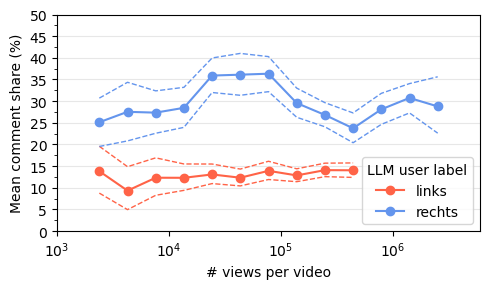

In [ ]:
# Plot 1: cross-partisan (links→RIGHT, rechts→LEFT)
color_map = {'links on RIGHT':'tomato', 'rechts on LEFT':'cornflowerblue'}
label_map = {'links on RIGHT': 'links','rechts on LEFT': 'rechts'}

plt.figure(figsize=(5,3))
for grp in ['links on RIGHT','rechts on LEFT']:
    s = agg_cross[agg_cross['group'] == grp].sort_values('bin_mid')
    if s.empty: continue
    x = s['bin_mid']; y = s['mean']*100; ylo = s['ci_lo']*100; yhi = s['ci_hi']*100
    c = color_map[grp]
    plt.plot(x, y, marker='o', linestyle='-', color=c, label=label_map[grp])
    plt.plot(x, ylo, linestyle='--', linewidth=1, color=c)
    plt.plot(x, yhi, linestyle='--', linewidth=1, color=c)
    
plt.xscale('log'); plt.xlim(1000, max_views)
plt.xlabel('# views per video'); 
plt.gca().xaxis.set_minor_formatter(NullFormatter())
plt.gca().xaxis.set_minor_locator(NullLocator())
plt.gca().xaxis.set_major_formatter(FuncFormatter(custom_log_formatter))

plt.ylabel('Mean comment share (%)')
plt.gca().set_ylim(0, 50)
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.gca().yaxis.set_minor_locator(MultipleLocator(2.5))
plt.gca().grid(axis='y',  alpha=0.3)
#plt.title('Cross-partisan interaction by video (≥ 1,000 views)')
plt.legend(title="LLM user label")
plt.tight_layout(); 
plt.show()

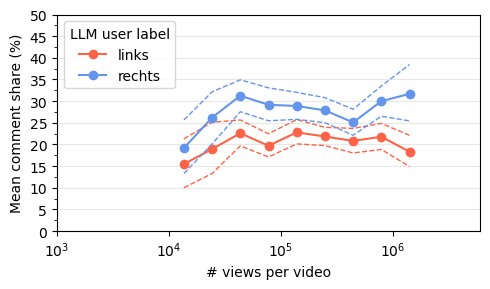

In [ ]:
#Plot 2: news/science (both lines in one)
color_map_news = {'links on NEWS/SCIENCE':'tomato', 'rechts on NEWS/SCIENCE':'cornflowerblue'}
label_map = {
    'links on NEWS/SCIENCE': 'links',
    'rechts on NEWS/SCIENCE': 'rechts'
}
plt.figure(figsize=(5,3))
for grp in ['links on NEWS/SCIENCE','rechts on NEWS/SCIENCE']:
    s = agg_news[agg_news['group'] == grp].sort_values('bin_mid')
    if s.empty: continue
    x = s['bin_mid']; y = s['mean']*100; ylo = s['ci_lo']*100; yhi = s['ci_hi']*100
    c = color_map_news[grp]
    plt.plot(x, y, marker='o', linestyle='-', color=c, label=label_map[grp])
    plt.plot(x, ylo, linestyle='--', linewidth=1, color=c)
    plt.plot(x, yhi, linestyle='--', linewidth=1, color=c)

plt.xscale('log'); plt.xlim(1000, max_views)
plt.xlabel('# views per video'); 
plt.gca().xaxis.set_minor_formatter(NullFormatter())
plt.gca().xaxis.set_minor_locator(NullLocator())
plt.gca().xaxis.set_major_formatter(FuncFormatter(custom_log_formatter))

plt.ylabel('Mean comment share (%)')
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.gca().yaxis.set_minor_locator(MultipleLocator(2.5))
plt.gca().set_ylim(0, 50)
plt.gca().grid(axis='y',  alpha=0.3)
plt.legend(title="LLM user label")
#plt.title('News/Science interaction by video (≥ 1,000 views)')

plt.tight_layout(); 
plt.show()

### % Cross Talk

In [ ]:

# all_df: ALL comments (identified + unidentified)
# filtered_df: ONLY comments from users with a clear political leaning

df_all = merge_df.copy()
df_id  = filtered_df.copy()

# Build the identified subset used to detect cross-partisan comments
use = df_id.copy()

# Normalize leaning labels per comment
lean = use['leaning'].astype(str).str.lower()
leftish   = lean.isin(['left', 'left-center'])
rightish  = lean.isin(['right', 'right-center'])
neutral   = lean.isin(['news/science'])

# keep only rows with a recognized leaning bucket
use = use[leftish | rightish | neutral].copy()

is_links  = use['user_label_llm'].eq('links')
is_rechts = use['user_label_llm'].eq('rechts')

# Per-comment cross indicator (on IDENTIFIED comments)
use['cross_ind'] = (is_links & rightish) | (is_rechts & leftish) | ((is_links | is_rechts) & neutral)

# Aggregate per channel
# Numerators from IDENTIFIED comments
agg_ident = (use.groupby('channel_id', as_index=False)
               .agg(
                   n_ident=('user_label_llm', 'size'),
                   n_left =('user_label_llm', lambda s: (s == 'links').sum()),
                   n_right=('user_label_llm', lambda s: (s == 'rechts').sum()),
                   n_cross_ident=('cross_ind', 'sum')  # count of cross-indicator True
               ))

# Denominator from ALL comments
tot_all = (df_all.groupby('channel_id', as_index=False)
                 .size()
                 .rename(columns={'size': 'n_comments_all'}))

# Channel metadata from ALL comments
channel_meta = (df_all[['channel_id','leaning','channel_category']]
                .drop_duplicates())

# Merge
pooled_all = (channel_meta
              .merge(agg_ident, on='channel_id', how='left')
              .merge(tot_all,    on='channel_id', how='left'))

# Fill NAs
for col in ['n_ident','n_left','n_right','n_cross_ident','n_comments_all']:
    pooled_all[col] = pooled_all[col].fillna(0).astype(int)

# Cross fraction for LEFT/RIGHT channels:
# share of cross-identified comments relative to sum of both on the channel
with np.errstate(divide='ignore', invalid='ignore'):
    cross_frac_lr = np.where(pooled_all['n_comments_all'] > 0,
                             pooled_all['n_cross_ident'] / (pooled_all['n_left']+pooled_all["n_right"]),
                             0.0)

#  News science: 1 - |%left - %right| with sum of both as denominator
lean_norm = pooled_all['leaning'].astype(str).str.lower()
is_neutral_ch = lean_norm.isin(['news/science'])

with np.errstate(divide='ignore', invalid='ignore'):
    cross_neutral = 1.0 - (np.abs(pooled_all["n_left"]-pooled_all["n_right"])/(pooled_all["n_left"]+pooled_all["n_right"]))


# --- Final cross_frac: LR channels use cross_frac_lr; news/science use cross_neutral
pooled_all['cross_frac'] = cross_frac_lr
pooled_all.loc[is_neutral_ch, 'cross_frac'] = cross_neutral[is_neutral_ch]

# Presentation
pooled_all['cross_frac_pct'] = (pooled_all['cross_frac'] * 100).round(2)



In [ ]:
## Bootstrapping Cross Talk

def boot_bin_cross_talk(x, B=5000, m_frac=0.7, replace=True, alpha=0.05, rng=None, return_reps=False):

    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = x.size

    if n == 0:
        summary = pd.Series({
            'mean_cross': np.nan,
            'mean_se_boot': np.nan,
            'ci_lo': np.nan,
            'ci_hi': np.nan,
            'n_channels': 0
        })
        return (summary, np.array([])) if return_reps else summary

    m = int(np.ceil(m_frac * n))
    rng = rng or np.random.default_rng()

    means = np.empty(B, dtype=float)
    for b in range(B):
        idx = rng.choice(n, size=m, replace=replace)
        means[b] = x[idx].mean()

    mean_pt = float(means.mean())
    se_boot = float(means.std(ddof=1))
    ci_lo, ci_hi = np.percentile(means, [100 * alpha / 2, 100 * (1 - alpha / 2)])

    summary = pd.Series({
        'mean_cross': mean_pt,
        'mean_se_boot': se_boot,
        'ci_lo': float(ci_lo),
        'ci_hi': float(ci_hi),
        'n_channels': int(n)
    })

    return summary, means if return_reps else summary


In [54]:
# Storage for bootstrap summaries and optional replicate samples
boot_summaries = []
boot_reps_rows = []

# Loop over channel categories
for category, sub in pooled_all.groupby("channel_category"):
    x = sub["cross_frac_pct"].to_numpy()

    # Apply bootstrapping (set return_reps=True if you want the full distribution)
    summary, reps = boot_bin_cross_talk(x, return_reps=True)

    # Store summary
    summary["channel_category"] = category
    boot_summaries.append(summary)

    # Store reps (for visualization)
    for val in reps:
        boot_reps_rows.append({"channel_category": category, "rep_mean": val})

# Create result DataFrames
boot_summary = pd.DataFrame(boot_summaries)
boot_reps_df = pd.DataFrame(boot_reps_rows)



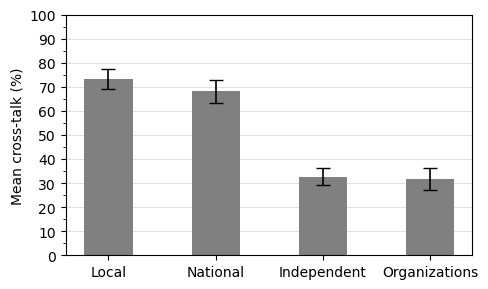

In [ ]:
# Visualizing Cross-talk estimates
label_map={"Local Media":"Local", "National Media":"National", "Organizations":"Organizations", "Independent Media": "Independent"}


# Rename columns to match expected names
summary_category_pct = boot_summary.rename(columns={
    'mean': 'mean_cross',
    'mean_se_boot': 'mean_se_boot',
    'ci_lo': 'ci_lo',
    'ci_hi': 'ci_hi',
    'n_videos': 'n_videos'
})
# Sort categories by mean_cross
summary_category_pct = summary_category_pct.sort_values('mean_cross', ascending=False)
categories = summary_category_pct['channel_category'].tolist()
x_idx = np.arange(len(categories))

# Plot
fig, ax = plt.subplots(figsize=(5,3))

ax.bar(
    x_idx,
    summary_category_pct['mean_cross'],
    yerr=summary_category_pct['mean_se_boot'],
    width=0.45,
    color='grey',
    capsize=5,
    error_kw={'elinewidth': 1.2}
)
ax.set_xticks(x_idx)
ax.set_xticklabels([label_map.get(label,label) for label in categories], rotation=0, ha='center')
ax.set_ylabel('Mean cross-talk (%)')
ax.set_xlabel('')
ax.set_ylim(0, 100)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.grid(axis='y', linewidth=0.7, alpha=0.4)
ax.grid(axis='x', visible=False) 
ax.set_axisbelow(True)

fig.tight_layout()
plt.show()


In [ ]:
# Make category labels shorter
boot_reps_df['cat_label'] = boot_reps_df['channel_category'].map(label_map)

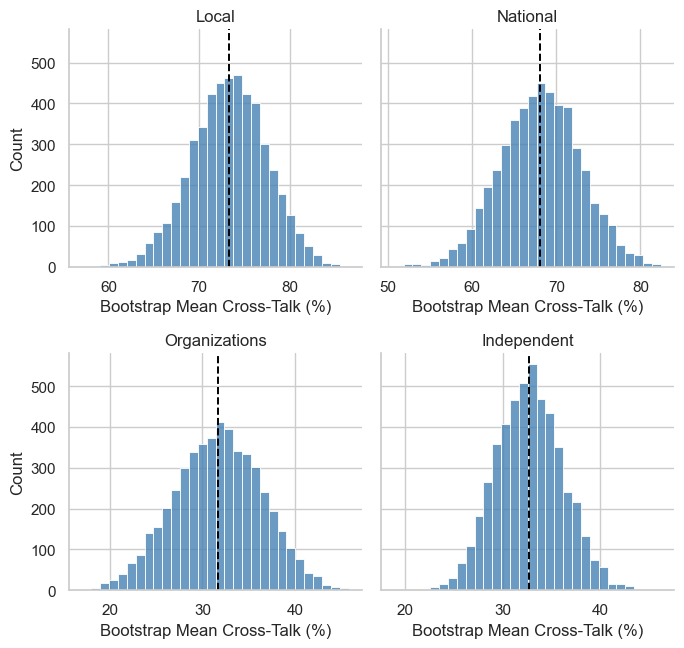

In [ ]:
# Visualizing bootstrapping

# Define category order
cat_order = ['Local', 'National', 'Organizations', 'Independent']
boot_reps_df['cat_label'] = pd.Categorical(boot_reps_df['cat_label'], categories=cat_order, ordered=True)

# Set seaborn style
sns.set(style="whitegrid")

# Create FacetGrid for bootstrap distributions
g = sns.FacetGrid(boot_reps_df, col="cat_label", col_wrap=2, height=3.5, sharex=False, sharey=True)

# Histogram + mean line per facet
g.map_dataframe(
    sns.histplot, x="rep_mean", bins=30, kde=False, color="steelblue", alpha=0.8
)

# Add mean line manually
for ax, cat in zip(g.axes.flat, cat_order):
    sub = boot_reps_df[boot_reps_df['cat_label'] == cat]
    if not sub.empty:
        mean_val = sub['rep_mean'].mean()
        ax.axvline(mean_val, color='black', linestyle='--', linewidth=1.4)
        ax.set_title(cat)
        ax.set_xlabel("Bootstrap Mean Cross-Talk (%)")
        ax.set_ylabel("Count")

#g.fig.suptitle("Bootstrap Distributions of Cross-Talk by Channel Category", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()